In [17]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Initial coefficients: b0(0) = 0.7702-0.4207j, b1(0) = -0.2298-0.4207j


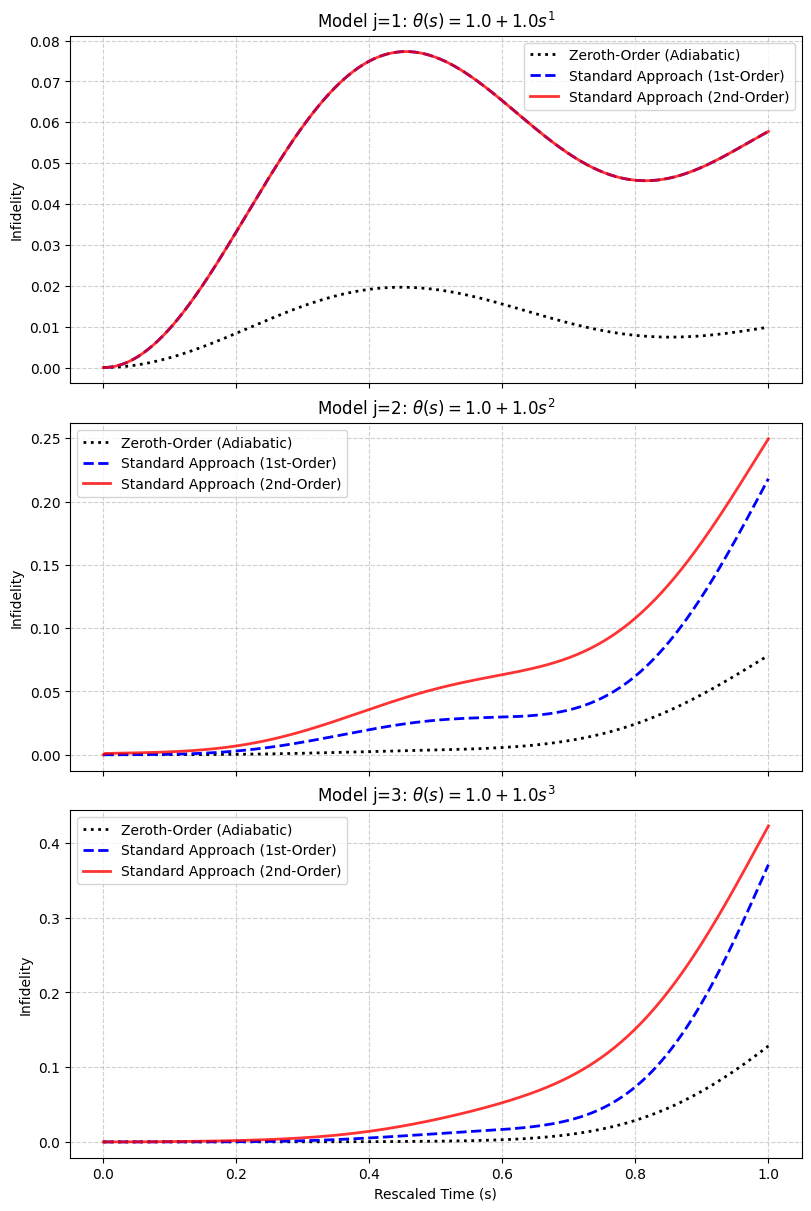

In [34]:
# 参数
E = 1.0
hbar = 1.0
v = 0.5
w = 1.0 
theta0 = 1.0
epsilon = E / (v * hbar)

s_span = [0, 1]
s_eval = np.linspace(s_span[0], s_span[1], 400)

def get_theta(s, j, w_j):
    return theta0 + w_j * (s**j)

def get_theta_dot(s, j, w_j):
    if s <= 0 and j > 1: return 0
    if j == 1: return w_j
    return w_j * j * (s**(j - 1))

def M10(s, j, w_j): return 1j * get_theta_dot(s, j, w_j) / 2.0
def M01(s, j, w_j): return 1j * get_theta_dot(s, j, w_j) / 2.0
def delta10(): return -2 * E
def delta01(): return 2 * E
def gamma0(s, j, w_j): return -0.5 * (get_theta(s, j, w_j) - theta0)
def gamma1(s, j, w_j): return -0.5 * (get_theta(s, j, w_j) - theta0)
def omega0(s): return E * s
def omega1(s): return -E * s

def ket0(s, j, w_j):
    phase = get_theta(s, j, w_j)
    return (1/np.sqrt(2)) * np.array([np.exp(1j * phase), 1], dtype=complex)

def ket1(s, j, w_j):
    phase = get_theta(s, j, w_j)
    return (1/np.sqrt(2)) * np.array([np.exp(1j * phase), -1], dtype=complex)

def ket_initial_new():
    return (1/np.sqrt(2)) * np.array([1, 1], dtype=complex)

def calculate_initial_b_coeffs(j, w_j):
    psi_new_0 = ket_initial_new()
    ket0_0 = ket0(0, j, w_j)
    ket1_0 = ket1(0, j, w_j)
    b0_0 = np.vdot(ket0_0, psi_new_0)
    b1_0 = np.vdot(ket1_0, psi_new_0)
    return b0_0, b1_0

def solve_exact(j, w_j):
    def ode_system(s, y):
        c_up, c_down = y
        phase = get_theta(s, j, w_j)
        dc_up_ds = -1j * epsilon * np.exp(1j * phase) * c_down
        dc_down_ds = -1j * epsilon * np.exp(-1j * phase) * c_up
        return [dc_up_ds, dc_down_ds]
    y0 = ket_initial_new()
    sol = solve_ivp(ode_system, s_span, y0, t_eval=s_eval, rtol=1e-9, atol=1e-9)
    return sol.y

def solve_zeroth_order(j, w_j, b0_0, b1_0):
    """计算零阶近似解（绝热近似）"""
    psi_approx_0 = np.zeros((2, len(s_eval)), dtype=complex)
    for i, s in enumerate(s_eval):
        term0 = b0_0 * np.exp(-1j*omega0(s)/v) * np.exp(1j*gamma0(s,j,w_j)) * ket0(s,j,w_j)
        term1 = b1_0 * np.exp(-1j*omega1(s)/v) * np.exp(1j*gamma1(s,j,w_j)) * ket1(s,j,w_j)
        psi_approx_0[:, i] = term0 + term1
    return psi_approx_0

def solve_standard_approach(j, w_j, b0_0, b1_0):
    """计算一阶修正解"""
    psi_approx_1 = np.zeros((2, len(s_eval)), dtype=complex)
    for i, s in enumerate(s_eval):
        b0_corr_factor = (np.exp(1j*(gamma1(s,j,w_j)-gamma0(s,j,w_j))) * M01(s,j,w_j) /
                          (np.exp(1j*(omega1(s)-omega0(s))/v) * delta01()) - M01(0,j,w_j)/delta01())
        b0_s = b0_0 - 1j * hbar * v * b0_corr_factor * b1_0

        b1_corr_factor = (np.exp(1j*(gamma0(s,j,w_j)-gamma1(s,j,w_j))) * M10(s,j,w_j) /
                          (np.exp(1j*(omega0(s)-omega1(s))/v) * delta10()) - M10(0,j,w_j)/delta10())
        b1_s = b1_0 - 1j * hbar * v * b1_corr_factor * b0_0

        term0 = b0_s * np.exp(-1j*omega0(s)/v) * np.exp(1j*gamma0(s,j,w_j)) * ket0(s,j,w_j)
        term1 = b1_s * np.exp(-1j*omega1(s)/v) * np.exp(1j*gamma1(s,j,w_j)) * ket1(s,j,w_j)
        psi_approx_1[:, i] = term0 + term1
    return psi_approx_1

def solve_standard_approach_2nd_order(j, w_j, b0_0, b1_0):
    """计算二阶修正解"""
    psi_approx_2 = np.zeros((2, len(s_eval)), dtype=complex)

    def G_func(s, m, n):
        if m==1 and n==0:
            gamma_nm = gamma0(s,j,w_j) - gamma1(s,j,w_j)
            M_mn = M10(s,j,w_j)
            delta_mn = delta10()
            return np.exp(1j * gamma_nm) * M_mn / delta_mn
        elif m==0 and n==1:
            gamma_nm = gamma1(s,j,w_j) - gamma0(s,j,w_j)
            M_mn = M01(s,j,w_j)
            delta_mn = delta01()
            return np.exp(1j * gamma_nm) * M_mn / delta_mn
        else:
            return 0

    h = 1e-6
    dG10_ds_at_0 = (G_func(h, 1, 0) - G_func(-h, 1, 0)) / (2 * h)
    dG01_ds_at_0 = (G_func(h, 0, 1) - G_func(-h, 0, 1)) / (2 * h)

    for i, s in enumerate(s_eval):
        b0_1st_corr = -1j*hbar*v * (np.exp(1j*(gamma1(s,j,w_j)-gamma0(s,j,w_j))) * M01(s,j,w_j) /
                                  (np.exp(1j*(omega1(s)-omega0(s))/v) * delta01()) - M01(0,j,w_j)/delta01()) * b1_0
        b1_1st_corr = -1j*hbar*v * (np.exp(1j*(gamma0(s,j,w_j)-gamma1(s,j,w_j))) * M10(s,j,w_j) /
                                  (np.exp(1j*(omega0(s)-omega1(s))/v) * delta10()) - M10(0,j,w_j)/delta10()) * b0_0

        dG10_ds_at_s = (G_func(s + h, 1, 0) - G_func(s - h, 1, 0)) / (2 * h)
        dG01_ds_at_s = (G_func(s + h, 0, 1) - G_func(s - h, 0, 1)) / (2 * h)

        b0_2nd_corr = v**2 * 1j*hbar * (np.exp(-1j*(omega1(s)-omega0(s))/v)/delta01()*dG01_ds_at_s - 1/delta01()*dG01_ds_at_0) * b1_0
        b1_2nd_corr = v**2 * 1j*hbar * (np.exp(-1j*(omega0(s)-omega1(s))/v)/delta10()*dG10_ds_at_s - 1/delta10()*dG10_ds_at_0) * b0_0
        
        b0_s = b0_0 + b0_1st_corr + b0_2nd_corr
        b1_s = b1_0 + b1_1st_corr + b1_2nd_corr

        term0 = b0_s * np.exp(-1j*omega0(s)/v) * np.exp(1j*gamma0(s,j,w_j)) * ket0(s,j,w_j)
        term1 = b1_s * np.exp(-1j*omega1(s)/v) * np.exp(1j*gamma1(s,j,w_j)) * ket1(s,j,w_j)
        psi_approx_2[:, i] = term0 + term1
        
    return psi_approx_2

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True, constrained_layout=True)

b0_0, b1_0 = calculate_initial_b_coeffs(1, w)
print(f"Initial coefficients: b0(0) = {b0_0:.4f}, b1(0) = {b1_0:.4f}")

for j, ax in zip([1, 2, 3], axes):
    exact_solution = solve_exact(j, w)
    zeroth_order_solution = solve_zeroth_order(j, w, b0_0, b1_0)
    standard_solution_1st = solve_standard_approach(j, w, b0_0, b1_0)
    standard_solution_2nd = solve_standard_approach_2nd_order(j, w, b0_0, b1_0) # NEW
    
    results = {
        "Zeroth-Order (Adiabatic)": zeroth_order_solution,
        "Standard Approach (1st-Order)": standard_solution_1st,
        "Standard Approach (2nd-Order)": standard_solution_2nd
    }
    infidelities = {}
    for name, approx_sol in results.items():
        norm = np.linalg.norm(approx_sol, axis=0)
        approx_sol_normed = approx_sol / norm
        inner = np.sum(exact_solution.conj() * approx_sol_normed, axis=0)
        fidelity = np.abs(inner)**2
        infidelities[name] = np.abs(1 - fidelity)

    ax.plot(s_eval, infidelities["Zeroth-Order (Adiabatic)"], 'k:', lw=2, label='Zeroth-Order (Adiabatic)')
    ax.plot(s_eval, infidelities["Standard Approach (1st-Order)"], 'b--', lw=2, label='Standard Approach (1st-Order)')
    ax.plot(s_eval, infidelities["Standard Approach (2nd-Order)"], 'r-', lw=2, alpha=0.8, label='Standard Approach (2nd-Order)')
    
    ax.set_title(f'Model j={j}: $\\theta(s) = {theta0:.1f} + {w:.1f}s^{j}$')
    ax.set_ylabel('Infidelity')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
axes[-1].set_xlabel('Rescaled Time (s)')
plt.show()